In [66]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
"""
Conv: Floor((W - F + 2 * P)/S + 1)

Pooling: Floor((W - F)/S + 1)

TransposeConv: (W - 1) * S - 2 * P + D * (F - 1) + 1

Torch dimensions: B x C x Z x H x W
"""

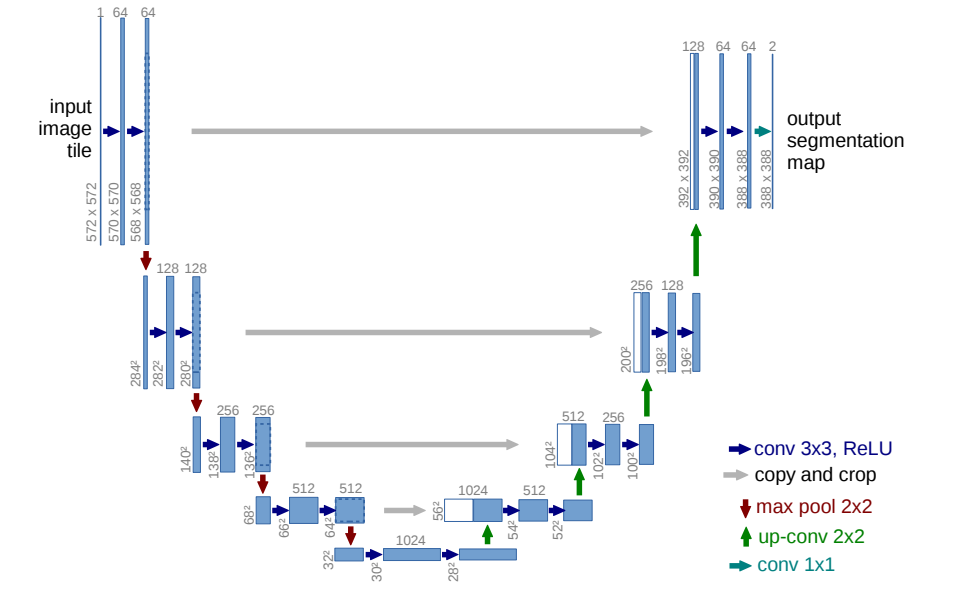

In [7]:
class ConvUnit(nn.Module):
    """Convolution Unit: (Conv3D -> BatchNorm -> ReLu) * 2
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.double_conv(x)
    
    
class EncoderUnit(nn.Module):
    """Encoder Unit with the ConvUnit and MaxPool
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.MaxPool3d(kernel_size=2),
            ConvUnit(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.encoder(x)
    
    
class DecoderUnit(nn.Module):
    """ConvUnit and upsample with Upsample and ConvTranspose
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose3d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvUnit(in_channels, out_channels)
        
    def forward(self, x1, x2):
        
        x1 = self.up(x1)
        diff_z = x2.size()[2] - x1.size()[2]
        diff_y = x2.size()[3] - x1.size()[3]
        diff_x = x2.size()[4] - x1.size()[4]
        x1 = F.pad(
            x1, 
            [
                diff_x // 2, 
                diff_x - diff_x // 2, 
                diff_y // 2,
                diff_y - diff_y // 2,
                diff_z // 2,
                diff_z - diff_z // 2
            ]
        )
        x = torch.cat([x2, x1], dim=1)
        
        return self.conv(x)
    

class OutConv(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv3d(in_channels, out_channels, kernel_size=1)
        
    def forward(self, x):
        return self.conv(x)
    
    
class Unet3D(nn.Module):
    
    def __init__(self, in_channels, n_classes, s_channels):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.s_channels = s_channels
        
        self.conv = ConvUnit(in_channels, s_channels)
        self.enc1 = EncoderUnit(s_channels, 2 * s_channels)
        self.enc2 = EncoderUnit(2 * s_channels, 4 * s_channels)
        self.enc3 = EncoderUnit(4 * s_channels, 8 * s_channels)
        self.enc4 = EncoderUnit(8 * s_channels, 8 * s_channels)

        self.dec1 = DecoderUnit(16 * s_channels, 4 * s_channels)
        self.dec2 = DecoderUnit(8 * s_channels, 2 * s_channels)
        self.dec3 = DecoderUnit(4 * s_channels, s_channels)
        self.dec4 = DecoderUnit(2 * s_channels, s_channels)

        self.out = OutConv(s_channels, n_classes)
    
    def forward(self, x):
        
        x1 = self.conv(x)
        x2 = self.enc1(x1)
        x3 = self.enc2(x2)
        x4 = self.enc3(x3)
        x5 = self.enc4(x4)
        
        mask = self.dec1(x5, x4)
        mask = self.dec2(mask, x3)
        mask = self.dec3(mask, x2)
        mask = self.dec4(mask, x1)
        mask = self.out(mask)
        
        return mask, x5

## TODO! Check dimensions for DecoderUnit!

In [16]:
import os
import glob
import random
import warnings

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import nrrd
from skimage.util import montage
import matplotlib.pyplot as plt

In [79]:
path_segmentation = os.path.join(os.getcwd(), '..', 'data', 'segmentation')

data = []

n_files = 103

for i in tqdm(range(1, n_files)):
    
    path_image = os.path.join(path_segmentation, f'{i}.nrrd')
    path_mask = os.path.join(path_segmentation, f'{i}_Segmentation.nrrd')
    
    image, header = nrrd.read(path_image)
    
    if os.path.isfile(path_mask):
        
        mask, header = nrrd.read(path_mask)
        
        try:
            assert image.shape == mask.shape
        except AssertionError:
            print(i, image.shape, mask.shape)
    else:
        mask = None
            
    data.append({
        'image': path_image.split(os.sep)[-1],
        'image_slices': image.shape[0],
        'image_height': image.shape[1],
        'image_width': image.shape[2],
        'mask': path_mask.split(os.sep)[-1] if isinstance(mask, np.ndarray) else pd.NaT,
        'mask_slices': mask.shape[0] if isinstance(mask, np.ndarray) else pd.NaT,
        'mask_height': mask.shape[1] if isinstance(mask, np.ndarray) else pd.NaT,
        'mask_width': mask.shape[2] if isinstance(mask, np.ndarray) else pd.NaT,
        'slices_positive': (mask > 0).any(axis=(1, 2)).sum() if isinstance(mask, np.ndarray) else pd.NaT,
        'positive_pixels_ratio': mask[mask == 1].sum() / len(mask.flatten()) if mask is not None else pd.NaT
    })
    
df = pd.DataFrame(data)

df['positive_ratio'] = df['slices_positive'] / df['image_slices']
condition = df['positive_ratio'].notnull()
df.loc[condition, 'positive_slice_ratio'] = df.loc[condition, 'positive_ratio'].apply(lambda x: f'{x:.2f} %')


  0%|          | 0/102 [00:00<?, ?it/s]

In [80]:
df.head()

,image,image_slices,image_height,image_width,mask,mask_slices,mask_height,mask_width,slices_positive,positive_pixels_ratio,positive_ratio,positive_slice_ratio
0,1.nrrd,62,64,64,1_Segmentation.nrrd,62,64,64,11,0.002788,0.177419,0.18 %
1,2.nrrd,64,64,64,2_Segmentation.nrrd,64,64,64,9,0.001781,0.140625,0.14 %
2,3.nrrd,64,64,64,3_Segmentation.nrrd,64,64,64,12,0.006973,0.1875,0.19 %
3,4.nrrd,64,64,64,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN
4,5.nrrd,128,128,128,5_Segmentation.nrrd,128,128,128,22,0.001923,0.171875,0.17 %


In [84]:
df.to_csv(os.path.join(os.getcwd(), '..', 'data', 'eda', 'spect_data.csv'), index=False)

In [81]:
class Visualizer:
    
    def montage_nrrd(self, image):
        if len(image.shape) > 2:
            return montage(image)
        else:
            warnings.warn('Pass a 3D volume', RuntimeWarning)
            return image
        
    def visualize(self, image, mask):
        fig, axes = plt.subplots(1, 2, figsize=(40, 40))
        for i, data in enumerate([image, mask]):
            axes[i].imshow(self.montage_nrrd(data))
            axes[i].set_axis_off()

In [82]:
file_image, file_mask = tuple(df.loc[0, ["image", "mask"]])

path_image = os.path.join(path_segmentation, file_image)
path_mask = os.path.join(path_segmentation, file_mask)

image, header = nrrd.read(path_image)
mask, header = nrrd.read(path_mask)

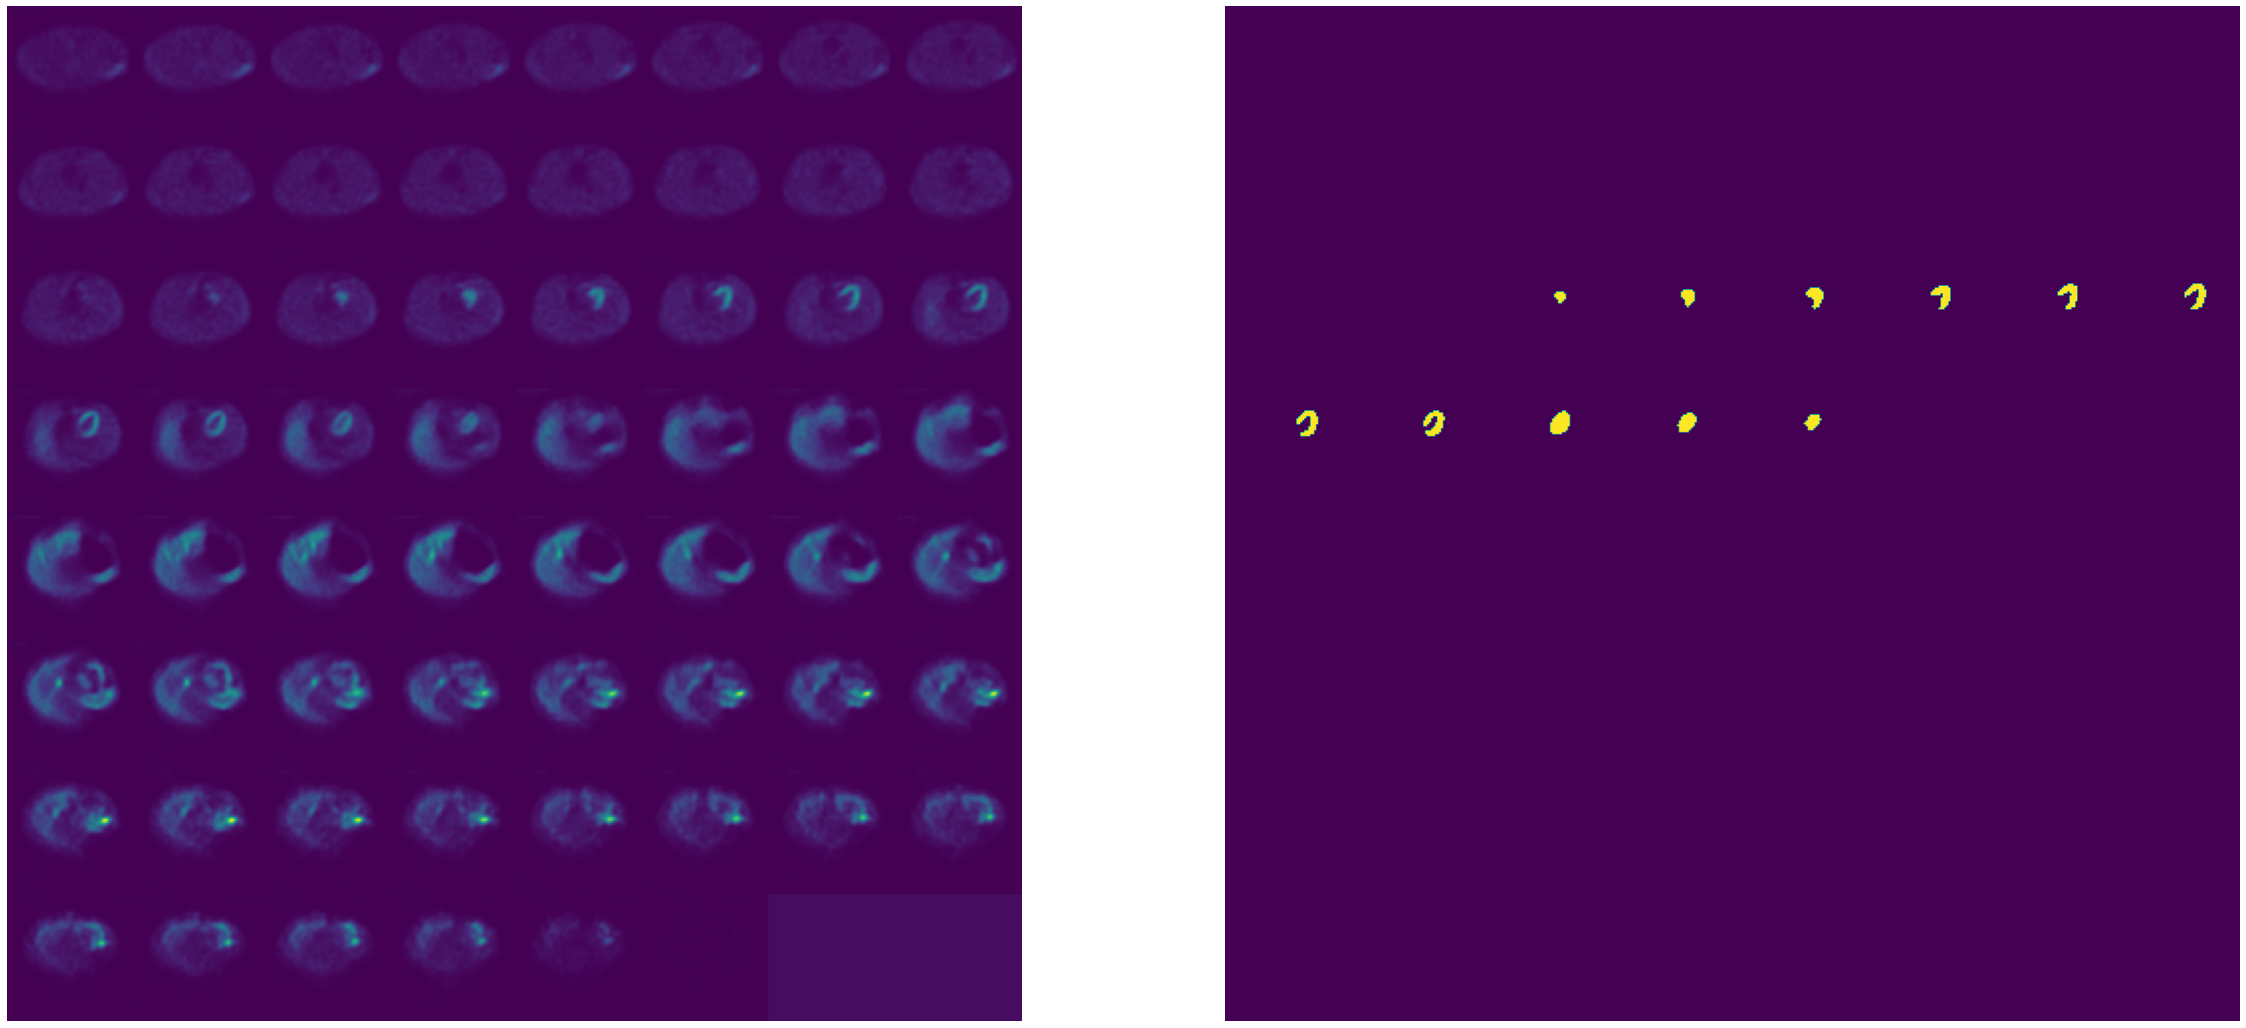

In [83]:
vis = Visualizer()

vis.visualize(image, mask)